In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.api as sm
import pandas_datareader as pdr
import datetime as dt
import seaborn as sns

# <font face="gotham" color="purple"> Pandas-datareader</font>

From here on, we will practice on real data via ```pandas-datareader``` which is library for retrieving data from various databases, such as FRED, World Bank, Stooq, and etc. 

Let's take a quick look how to use it.

##  <font face="gotham" color="purple"> FRED</font>

Federal Reserve Economic Data (FRED) is a database maintained by the Research division of the Federal Reserve Bank of St. Louis that has more than 765,000 economic time series from 96 sources. For macroeconomic researches, this is the database you need almost every day.

In [2]:
class Data:
    def __init__(self, **kwargs):
        '''Input start, end, database'''
        self.__dict__.update(kwargs)
#         self.start = start
#         self.end = end
#         self.database = database 
    
    def retrieve(self, data_id):
        if self.database == 'fred':
            self.df = pdr.data.DataReader(data_id, self.database , start, end)
        elif self.database == 'oecd':
            self.df = pdr.data.DataReader(data_id, self.database)
        elif self.database == 'eurostat':
            self.df = pdr.data.DataReader(data_id, self.database)
        
    def normalise(self):
        self.df_normalised = self.df/self.df.iloc[1]
            
    def plot(self, labels, grid_on, norm):
        if norm == False:
            self.labels = labels
            self.grid_on = grid_on
            
            fig, ax = plt.subplots(figsize=(14, 8))
            for col, label in zip(self.df, self.labels):  # for drawing multiple labels/legends
                ax.plot(self.df_normalised[col], label=label)
            ax.grid(grid_on)
            ax.legend()
            plt.show()
        else:
            self.label = labels
            self.grid_on = grid_on
            
            fig, ax = plt.subplots(figsize=(14, 8))
            for col, label in zip(self.df_normalised, self.label):
                ax.plot(self.df_normalised[col], label=label)
            ax.legend()
            ax.grid(grid_on)
            plt.show()
            
    def twin_plot(self, lhs, rhs, labels, grid_on, ax_rhs_inverse, lhs_color, rhs_color):
        self.lhs = lhs
        self.rhs = rhs
        self.labels = labels
        self.grid_on = grid_on
        self.ax_rhs_inverse = ax_rhs_inverse
        self.lhs_color = lhs_color
        self.rhs_color = rhs_color
        
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(self.df[self.lhs].dropna(), label=labels[0], color = self.lhs_color)
        ax.legend(loc=3)
        ax_RHS = ax.twinx() # share the same x-axis
        ax_RHS.plot(self.df[self.rhs].dropna(), label=labels[1], color = self.rhs_color)
        ax_RHS.legend(loc=0)
        if ax_rhs_inverse == True:
            ax_RHS.invert_yaxis()
        ax.grid(grid_on)
        plt.show()

###  <font face="gotham" color="purple"> Stock Index Plot</font>

In [3]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2021, 7, 1)
fred_stock = Data(start = start, end = end, database = 'fred')
fred_stock.retrieve(['NASDAQCOM','SP500','DJIA'])

In [4]:
fred_stock.df.head(5)

,NASDAQCOM,SP500,DJIA
DATE,,,
2015-01-01,NaN,NaN,NaN
2015-01-02,4726.81,2058.20,17832.99
2015-01-05,4652.57,2020.58,17501.65
2015-01-06,4592.74,2002.61,17371.64
2015-01-07,4650.47,2025.90,17584.52


In [5]:
fred_stock.normalise()
fred_stock.df_normalised.head(5)

,NASDAQCOM,SP500,DJIA
DATE,,,
2015-01-01,NaN,NaN,NaN
2015-01-02,1.000000,1.000000,1.000000
2015-01-05,0.984294,0.981722,0.981420
2015-01-06,0.971636,0.972991,0.974129
2015-01-07,0.983850,0.984307,0.986067


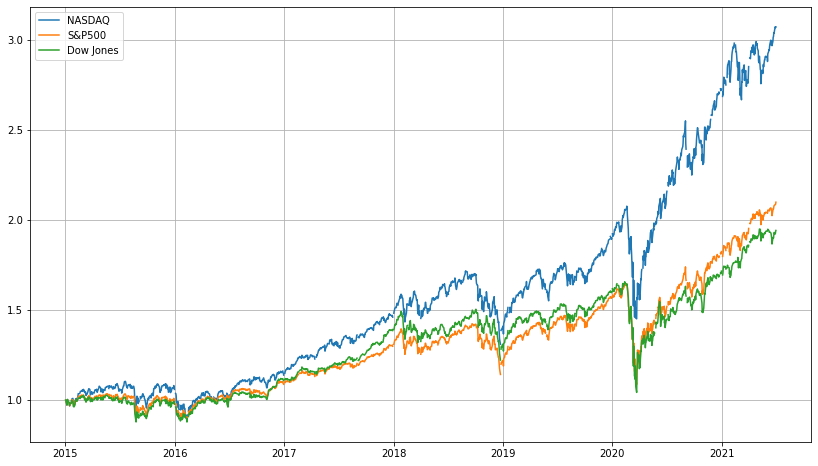

In [6]:
fred_stock.plot(labels=['NASDAQ','S&P500','Dow Jones'], grid_on=True, norm=True)

###  <font face="gotham" color="purple"> Exchange Rate Plot</font>

In [7]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2021, 7, 1)
fx = Data(start = start, end = end, database = 'fred')
fx.retrieve(['DEXCHUS','DEXJPUS', 'DEXUSEU']) # 'USD/CNY','USD/JPY','EUR/USD'

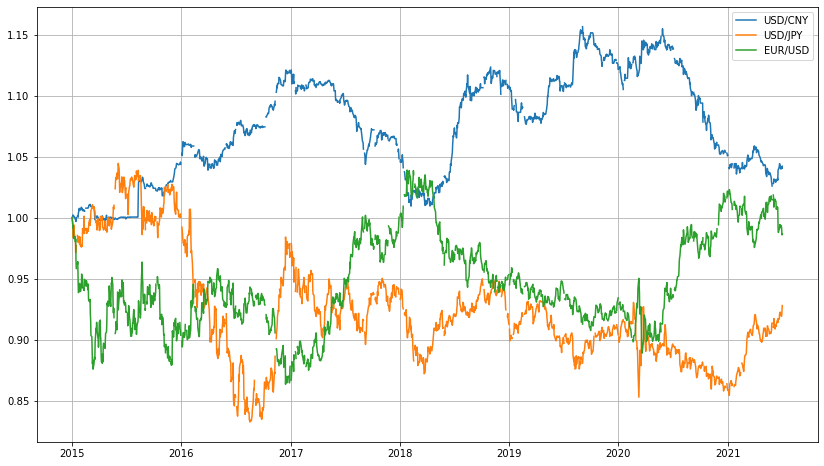

In [8]:
fx.normalise()
fx.plot(labels=['USD/CNY','USD/JPY','EUR/USD'], grid_on=True, norm=True)

###  <font face="gotham" color="purple"> Twin Axes Plot</font>

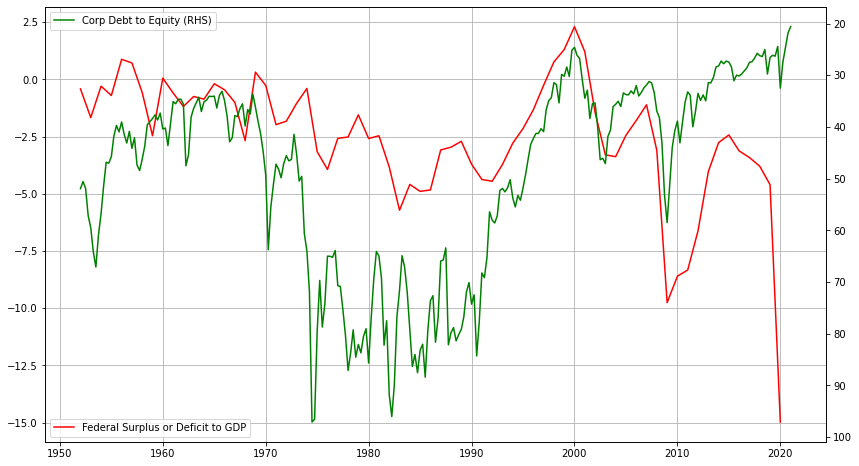

In [9]:
start = dt.datetime(1952, 1, 1)
end = dt.datetime.today()
debt = Data(start = start, end = end, database = 'fred')
debt.retrieve(['FYFSGDA188S','NCBCMDPMVCE'])
debt.twin_plot(lhs = 'FYFSGDA188S', rhs = 'NCBCMDPMVCE',
               labels = ['Federal Surplus or Deficit to GDP', 'Corp Debt to Equity (RHS)'], 
               grid_on = True, ax_rhs_inverse = True, 
               lhs_color = 'r', rhs_color = 'g')

In [ ]:
from pandas_datareader import wb

govt_debt = wb.download(indicator='GC.DOD.TOTL.GD.ZS', country=['US', 'AU'], start=2005, end=2016).stack().unstack(0)
ind = govt_debt.index.droplevel(-1)
govt_debt.index = ind
ax = govt_debt.plot(lw=2)
ax.set_xlabel('year', fontsize=12)
plt.title("Government Debt to GDP (%)")
plt.show()

In [ ]:
eurostat = Data(database = 'eurostat')
eurostat.retrieve('tran_sf_railac')

# <font face="gotham" color="purple"> Two Independent Variable Regression</font>

The regression model with two independent variables are often the representative pedagogic tool of multiple linear regression. We start from here too, here is the model:
$$
Y_{i}=\beta_{1}+\beta_{2} X_{2 i}+\beta_{3} X_{3 i}+u_{i}
$$
$X_{2 i}$ and $X_{3 i}$ are the indexed independent variables. 

Without disturbance term, the model is merely a function of a plane in $\mathbb{R}^3$, such as
$$
Y = 1 + 2X_2 + 3X_3
$$
We can visualise the plane and data points.

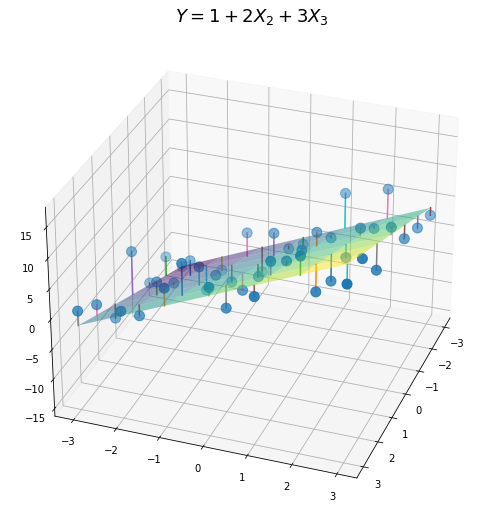

In [33]:
x2, x3 = np.arange(-3, 4, 1), np.arange(-3, 4, 1)
X2, X3 = np.meshgrid(x2, x3) # this is coordinates on X2-X3 plane
u = np.random.randn(7, 7)*3
Y = 1 + 2*X2 + 3*X3 # plane without disturbance term
Yu = 1 + 2*X2 + 3*X3 + u # with disturbance term

fig = plt.figure(figsize = (9, 9))
ax = fig.add_subplot(111, projection = '3d')

ax.set_title('$Y=1+2X_2+3X_3$', size = 18)
ax.view_init(elev=30, azim=20)
ax.plot_surface(X2, X3, Y, cmap ='viridis', alpha=.5) # MATLAB default color map
ax.scatter(X2, X3, Yu, s = 100)

for i in range(len(X2.flatten())):
    ax.plot([X2.flatten()[i],X2.flatten()[i]], [X3.flatten()[i],X3.flatten()[i]], [Y.flatten()[i], Yu.flatten()[i]])
plt.show()

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<b>Side Note:</b><br>
Matplotlib isn't able to draw real 3D plot, all the 3D plots are actually 2D projections. Too draw serious 3D graphs, <code>mayavi</code> and <code>plotly</code> are the better choices.
</div> 

The formulae of $b_1$, $b_2$ and $b_3$ are presented here without proofs 
\begin{align}
b_{1}&=\bar{Y}-b_{2} \bar{X}_{2}-b_{3} \bar{X}_{3}\\
b_{2}&=\frac{\operatorname{Cov}\left(X_{2}, Y\right) \operatorname{Var}\left(X_{3}\right)-\operatorname{Cov}\left(X_{3}, Y\right) \operatorname{Cov}\left(X_{2}, X_{3}\right)}{\operatorname{Var}\left(X_{2}\right) \operatorname{Var}\left(X_{3}\right)-\left[\operatorname{Cov}\left(X_{2}, X_{3}\right)\right]^{2}}\\
b_{3}&=\frac{\operatorname{Cov}\left(X_{3}, Y\right) \operatorname{Var}\left(X_{2}\right)-\operatorname{Cov}\left(X_{2}, Y\right) \operatorname{Cov}\left(X_{3}, X_{2}\right)}{\operatorname{Var}\left(X_{3}\right) \operatorname{Var}\left(X_{2}\right)-\left[\operatorname{Cov}\left(X_{3}, X_{2}\right)\right]^{2}}
\end{align}
The algebraic expressions are becoming exponentially burdensome as number of variables rises, therefore we won't even try to reproduce the derivation. But the general idea is always the same despite of number of independent variables—taking partial derivatives towards all $b$'s
$$
\begin{gathered}
\frac{\partial R S S}{\partial b_{1}}=-2 \sum_{i=1}^{n}\left(Y_{i}-b_{1}-b_{2} X_{2 i}-b_{3} X_{3 i}\right)=0 \\
\frac{\partial R S S}{\partial b_{2}}=-2 \sum_{i=1}^{n} X_{2 i}\left(Y_{i}-b_{1}-b_{2} X_{2 i}-b_{3} X_{3 i}\right)=0 \\
\frac{\partial R S S}{\partial b_{3}}=-2 \sum_{i=1}^{n} X_{3 i}\left(Y_{i}-b_{1}-b_{2} X_{2 i}-b_{3} X_{3 i}\right)=0
\end{gathered}
$$

## <font face="gotham" color="purple"> Cobb-Douglas Production Function </font>

The multiple regression coefficients represent each $X$'s influence on $Y$ while controlling all other $X$ variables. We will use the celebrated Cobb–Douglas (C-D) production function to demonstrate how this holds. The stochastic C-D function form is
$$
Y_i = A L_i^\beta K_i^\alpha e^{u_i}
$$
where $Y$ stands for output, $A$ for technology, $L$ for labor input, $K$ for capital input. And from lecture 2, we have known that $\alpha$ and $\beta$ are output elasticities of labor input and capital input. Take natural log, 
$$
\ln{Y_i} = \ln{A} + \beta \ln{L_i}+\alpha\ln{K_i} + u_i
$$
Estimation of $\alpha$ and $\beta$  gives information about _returns to scale_, i.e.
$$
\alpha+\beta = 1 \qquad \text{Constant returns to scale}\\
\alpha+\beta < 1 \qquad \text{Decreasing returns to scale}\\
\alpha+\beta > 1 \qquad \text{Increasing returns to scale}
$$

Import the data, which is from _Annual Survey of Manufacturers 2005_. 

In [34]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'US_CobbDauglas')
df.head()

,Area,Output Value Added (thousands of $),Labour Input Worker Hours (thousands),Capital Input (thousands)
0,Alabama,38372840,424471,2689076
1,Alaska,1805427,19895,57997
2,Arizona,23736129,206893,2308272
3,Arkansas,26981983,304055,1376235
4,California,217546032,1809756,13554116


The data record output, labor input and capital input from each states in 2005, enough for demonstration purpose. Let's take natural log of the data and change the columns' names. 

In [35]:
df = df[df.columns[1:4]] # pick the data columns
df = np.log(df) # take log on the data
df.head()

,Output Value Added (thousands of $),Labour Input Worker Hours (thousands),Capital Input (thousands)
0,17.462860,12.958599,14.804708
1,14.406308,9.898224,10.968147
2,16.982509,12.239957,14.652010
3,17.110680,12.624964,14.134862
4,19.197921,14.408703,16.422201


In [36]:
df.columns = ['ln_Y', 'ln_L', 'ln_K'] # change the names
df.head()

,ln_Y,ln_L,ln_K
0,17.462860,12.958599,14.804708
1,14.406308,9.898224,10.968147
2,16.982509,12.239957,14.652010
3,17.110680,12.624964,14.134862
4,19.197921,14.408703,16.422201


Now perform the OLS estimation.

In [37]:
X = df[['ln_L', 'ln_K']]
Y = df['ln_Y']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit() 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   ln_Y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     645.9
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           2.00e-35
Time:                        16:19:00   Log-Likelihood:                -3.4267
No. Observations:                  51   AIC:                             12.85
Df Residuals:                      48   BIC:                             18.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8876      0.396      9.812      0.0

Here are the estimated elasticities

In [38]:
print('alpha: {:.4f}    beta: {:.4f}'.format(model.params[2], model.params[1]))

alpha: 0.5213    beta: 0.4683


It means, ceteris paribus, $1\%$ raise of capital input led on $.52\%$ increase in output, $1\%$ raise of labor input led on $.47%$ increase in output.

Adding up the elasticities gives the parameter of returns to scale $.99$, given possible statistical errors, we could conclude a constant return to scale.

In [39]:
np.sum(model.params[2]+model.params[1])

0.9896113184066175

## <font face="gotham" color="purple">Adjusted $R^2$</font>

Probably you have heard that $R^2$ is monotonic increasing function of number of independent variables, i.e. $R^2$ will always increase as you add more independent variables in the model. This might give an illusion that the model has better explanatory power, on the contrary, adding many independent variables would cause inefficiency of estimators, which is the reason we usually have **adjusted $R^2$**, denote as $\bar{R}^2$, reported too.

$$
\bar{R}^{2}=1-\frac{\operatorname{RSS} /(n-k)}{\mathrm{TSS} /(n-1)}=1-\left(1-R^{2}\right) \frac{n-1}{n-k}
$$

As you can see the $\bar{R}^2$ is always smaller than $R^2$, therefore always use $\bar{R}^2$ in multivariable regression.

## <font face="gotham" color="purple"> Regression With Purged Variables</font>

What we want to demonstrate is that the multiple regression coefficients represent only the influence of their own variable, even though we purge the influence of other variables, the estimates are expected to be the same in multiple regression.

To purge the influence of $\ln{L}$ on $\ln{Y}$ and $\ln{K}$, we evaluate two regression models as below


$$
\ln{Y_i} = \gamma_1 + \gamma_2 \ln{L_i}+u^Y_i\\
\ln{K_i}= \zeta_1 + \zeta_2\ln{L_i}+v^K_i
$$

Perform the OLS estimation with ```statsmodels```.

In [41]:
ln_K = df['ln_K']
ln_L = df['ln_L']
ln_Y = df['ln_Y']

ln_L = sm.add_constant(ln_L) # adding a constant

model1 = sm.OLS(ln_Y, ln_L).fit()
model2 = sm.OLS(ln_K, ln_L).fit()


Next we retrieve the residual of both estimation, i.e. $\ln{Y_i}^{resid}$ and $\ln{K_i}^{resid}$, which are free of $\ln{L}$'s influence, the exact reason we call them 'purged'. 
$$
\ln{Y_i}^{resid}=\ln{Y_i}-\widehat{\ln{Y_i}} \\
\ln{K_i}^{resid}=\ln{K_i}-\widehat{\ln{K_i}} 
$$
Then regress $e^Y$ on $e^K$

In [42]:
ln_Y_resid = model1.resid
ln_K_resid = model2.resid

model3 = sm.OLS(ln_Y_resid, ln_K_resid).fit()
model3.params

x1    0.521279
dtype: float64

The estimate is exactly the same as in multiple regression.

# <font face="gotham" color="purple"> Multicollinearity</font>

It is common that variables are correlated with each other to some extent, for instance in Cobb-Douglas model, higher labor input might induce higher capital investment, because each labor requires some level of capital to produce. On the other hand, higher capital investment also requires more labor input, e.g. if office buildings are constructed, there will be more recruitment.

This phenomenon of correlated independent variables is termed **multicollinearity**.

But is multicollinearity desirable? _Hardly_.

In two variable regression case, the standard error of $b_2$ is
$$
\text { s.e. }\left(b_{2}\right)=\sqrt{\frac{s_{u}^{2}}{n \operatorname{Var}\left(X_{2}\right)} \times \frac{1}{1-r_{X_{2}, X_{3}}^{2}}}
$$

If you can recall the formula of single regression model, the difference is the part 
$$\sqrt{\frac{1}{1-r^2_{X_2, X_3}}}$$
where $r^2_{X_2, X_3}$ is the correlation coefficient. 

If hold other things constant, the larger the correlation, the smaller the denominator, then standard error is larger. This the exactly the reason we see multicollinearity as an undesirable feature. 

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<b>Perfect Multicollinearity</b><br><br>
And you probably have noticed there is a condition $r^2_{X_2, X_3}=1$ that makes the whole standard error formula invalid, this applies to any type of linear regression model, if any two independent variables perfectly correlated, the model will be invalid and can't be estimated either.<br><br>
    
Not only two variable cases, in the multiple regression, an independent variable might be a <a href='https://nbviewer.jupyter.org/github/WeijieChen-MacroAnalyst/Linear_Algebra_With_Python/blob/master/Chapter%206%20-%20Linear%20Combination.ipynb'>linear combination</a> of some other variables. It's would be arduous work to detect where correlations originate, because  pairwise correlation might seem totally normal.
</div>

Let's load the Cobb-Dauglas data again without log transformation. And compute correlation coefficient

In [ ]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'US_CobbDauglas')
df = df[df.columns[1:4]] # pick the data columns
df.columns = ['Y', 'L', 'K']
np.corrcoef(df['L'], df['K'])

It's not a surprise to see high correlation $.94$ between capital and labor, but the high correlation does not necessarily lead to poor estimates, as long as other factors are well-controlled, such as _large variance of independent variables_, _small variance of disturbance term_ and _large sample size_. 

We only talk about multicollinearity explicitly when independent variables are highly correlated and one or more of conditions above are also obstructive. 

Once you suspect multicollinearity presents, you should expect the following consequences.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<b>Consequences of Multicollinearity</b><br><br>
1. Wider confidence interval<br>
2. Insignificant $t$-statistic<br>
3. Though some $t$-statistic might be insignificant, but the $R^2$ can be misleadingly high<br>
4. Any data change might cause drastic estimation result
</div>

The first and the second are intuitive and they are the effects of larger standard errors.

The third consequence can be seen as an alert, especially when the estimation reports very few significant $t$-statistics, but $R^2$ are exceedingly high, this is a signal of severe multicollinearity. 

To understand why this is the case, we can perform Monte Carlo experiment of joint confidence region. Here is the simulated joint distribution of $\beta_2$ and $\beta_3$. We deliberately created $X_2$ and $X_3$ with linear relationship, i.e. $X_3 = 10 X_2+v$, so we are expecting the issue of multicollinearity in the estimation.

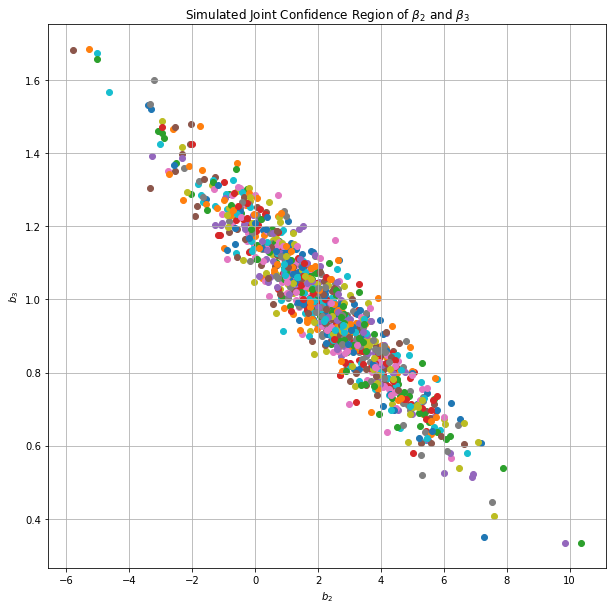

In [116]:
beta1, beta2, beta3 = 3, 2, 1 # pre-set the parameters
beta1_array, beta2_array, beta3_array = [], [], []
np.random.seed(100) # reproducible results
for i in range(1000):
    u = 100*np.random.randn(30)
    v = 100*np.random.randn(30)
    X2 = np.linspace(10, 100, 30)
    X3 = 10*X2 + v
    Y = beta1 + beta2*X2 + beta3*X3 + u

    df = pd.DataFrame([Y, X2, X3]).transpose()
    df.columns = ['Y', 'X2', 'X3']

    X_inde = df[['X2', 'X3']]
    Y = df['Y']

    X_inde = sm.add_constant(X_inde)

    model = sm.OLS(Y, X_inde).fit()
    beta1_array.append(model.params[0])
    beta2_array.append(model.params[1])
    beta3_array.append(model.params[2])
fig, ax = plt.subplots(figsize = (10, 10))
ax.grid()
for i in range(1000):
    ax.scatter(beta2_array[i], beta3_array[i]) # no need for a loop, i just want different colors
ax.set_xlabel(r'$b_2$')
ax.set_ylabel(r'$b_3$')
ax.set_title(r'Simulated Joint Confidence Region of $\beta_2$ and $\beta_3$')
plt.show()

From the plot, we can see that the distribution of $b_2$ include $0$, i.e. roughly in $[-6, 10]$, so in practice $b_2$ could have high chances to be insignificant, however $b_3$ is above $0$, we would expect $b_3$ to be highly significant. And also we can see the whole elliptic distribution is far away from origin $(0, 0)$, there even if $b_2$ is insignificant, the $F$-statistic will be exceedingly significant.

Here is the report of last regression in the loop, we notice that $b_2$ is insignificant and $b_2$ and $F$-test is highly significant as we expected.

This geometric view perfectly explains the $3$rd consequence of multicollinearity.

In [115]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     210.8
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           3.33e-17
Time:                        21:21:36   Log-Likelihood:                -176.49
No. Observations:                  30   AIC:                             359.0
Df Residuals:                      27   BIC:                             363.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1650     38.089      0.057      0.9

The forth consequences suggests that the estimated results are highly sensitive to data, even a minor change of single data point can cause erratic results. Just take it as a fact, we'll not demonstrate for now.

# <font face="gotham" color="purple"> Detection of Multicollinearity</font>

Like we mentioned before, multicollinearity is a question of degree rather than presence, we only address the issue when it is so severe that interferes all the estimation results. Here are some rules help you to detect multicollinearity.

## <font face="gotham" color="purple"> High $R^2$ but few significant $t$-statistic</font>

We have seen why this is the case above, you should consider this possibility when very few $t$-test are significant.

## <font face="gotham" color="purple"> High pairwise correlation</font>

If there are more than $2$ independent variables, check their pairwise correlation. You can compute correlation coefficient matrix with ```pandas``` and visualize with ```seaborn```. Here's an example.

In [164]:
n = 1000
x1 = np.random.randn(n)
x2 = np.random.rand(n)
x3 = sp.stats.t.rvs(100, loc=0, scale=1, size=n)
x4 = x2*x1-x3
x5 = x2/x3
x6 = np.log(x2)

In [165]:
df = pd.DataFrame([x1, x2, x3, x4, x5, x6]).T
df.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
df.corr()

,x1,x2,x3,x4,x5,x6
x1,1.000000,-0.000078,-0.027519,0.466904,0.003358,0.001061
x2,-0.000078,1.000000,0.045128,-0.047107,0.054698,0.868007
x3,-0.027519,0.045128,1.000000,-0.862179,0.034624,0.043339
x4,0.466904,-0.047107,-0.862179,1.000000,-0.020987,-0.043987
x5,0.003358,0.054698,0.034624,-0.020987,1.000000,0.030701
x6,0.001061,0.868007,0.043339,-0.043987,0.030701,1.000000


Or color the correlation matrix.

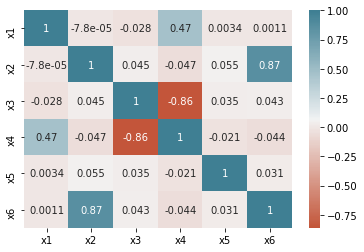

In [166]:
sns.heatmap(df.corr(), 
            annot = True, 
            cmap=sns.diverging_palette(20, 220, n=200)); plt.show()

Scatter plot is also a good choice for eyeballing the correlation. If you are not sure what it means to have high correlation, review Lecture 1's notes, we have demonstrated the difference between correlation and regression.

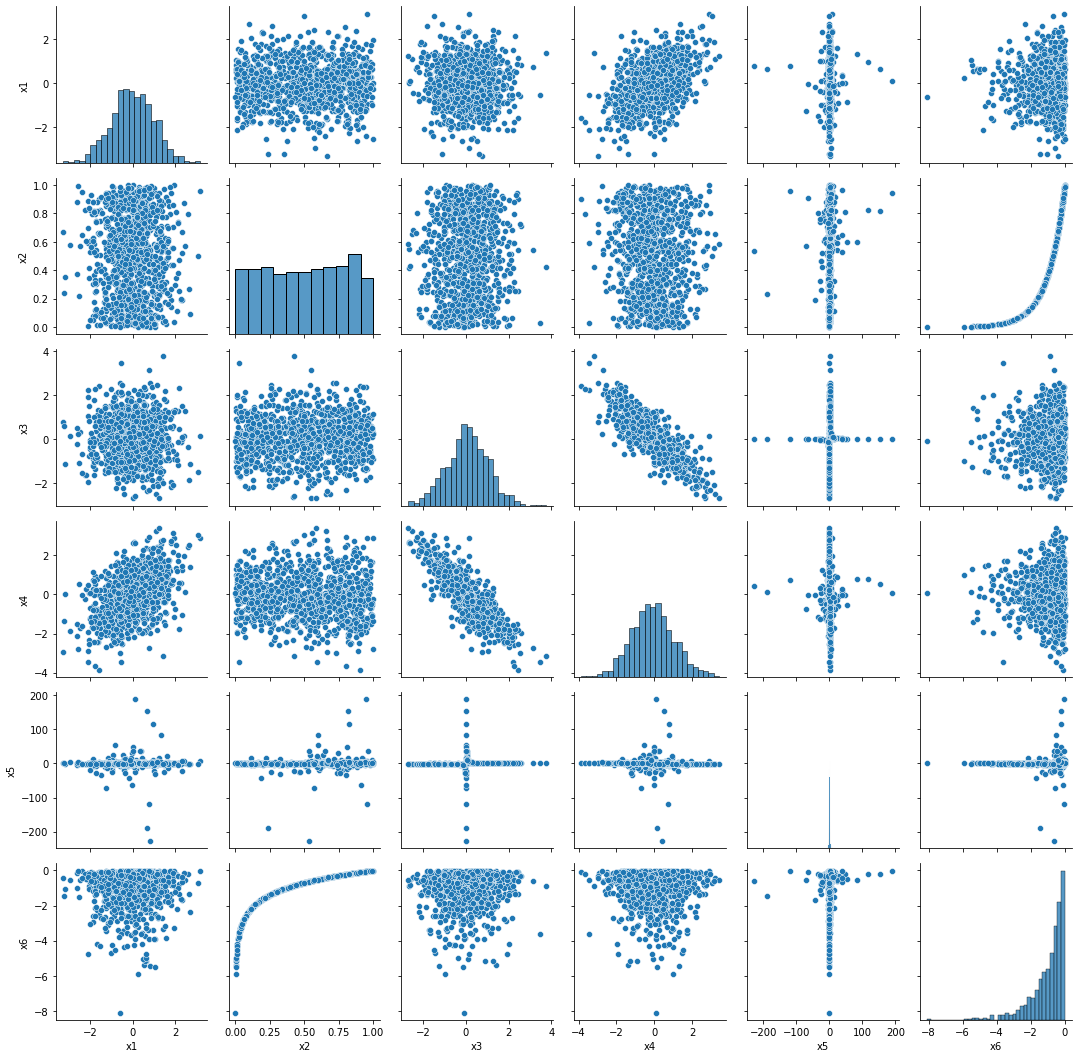

In [170]:
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

## <font face="gotham" color="purple"> Eigenvalue and Condition Index</font>

If you are using ```statsmodel``` library for estimation, you probably have notices there is note at the bottom of reports.
```
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
```
Once you see this note popped up, your sample is probably suffering from multicollinearity issue. But what is **condition  number**?

This is concept from linear algebra, essentially any dataset is a matrix if no missing values, naturally it could have an inverse matrix. If two columns are numerically similar but not exactly the same, it's still possible to calculate an inverse but we call it **ill-conditioned**, the inverse matrix will be immensely sensitive to any perturbation of the elements, this is exactly the $4$th consequence we mentioned.

To to specific, condition number is
$$
\kappa(X)=\frac{\left|\lambda_{\max }(X)\right|}{\left|\lambda_{\min }(X)\right|}
$$
where $\lambda_{\max }$ and $\lambda_{\min }$ are maximal and minimal eigenvalues of $X$, and $X$ is our dataset.

Then we have this _rule of thumb_: If $100 <k< 1000$ there is moderate to strong multicollinearity and if $k>1000$ there is severe multicollinearity.

# <font face="gotham" color="purple"> Remedy of Multicollinearity </font>

There are two types methods when comes to handling the multicollinearity. If you ever have a chance, choose the first type.

## <font face="gotham" color="purple"> Type I Method: Change the Sample</font>

The first type of method focusing on the solution provided by formula of standard error, for convenient demonstration, we will reproduce the standard error of two variable regression, but the ideas apply to all general cases. 

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
Type I Method is focusing on formula of standard error, e.g.
$$
\text { s.e. }\left(b_{2}\right)=\sqrt{\frac{s_{u}^{2}}{n \operatorname{Var}\left(X_{2}\right)} \times \frac{1}{1-r_{X_{2}, X_{3}}^{2}}}
$$
1. Increase sample size<br>
2. Increase variance of independent variables<br>
3. Decrease the variance of disturbance term<br>
i.e. find a better dataset, but most of time we don't have choices over available data, usually what we have are already the best choice. But the third one require some explanations, if you know by theory or some conjectures that certain independent variable $X$ should be included or excluded in the model, which might correct the certain level of **misspecification** and contracting $u$. 
</div> 

## <font face="gotham" color="purple"> Type II Method: Manipulate the Data</font>

### <font face="gotham" color="purple"> Transformation of Data</font>

The common method in time series model is **first order difference** which will be extensively used in time series chapter. If our time series model is 
$$
Y_{t}=\beta_{1}+\beta_{2} X_{2 t}+\beta_{3} X_{3 t}+u_{t}
$$
The first order difference is
$$
Y_{t}-Y_{t-1}=\beta_{2}\left(X_{2 t}-X_{2, t-1}\right)+\beta_{3}\left(X_{3 t}-X_{3, t-1}\right)+v_{t}
$$
where $v_t = u_t-u_{t-1}$.

First-order difference only makes sense on time series data and $v_t$ will be probably autocorrelated that cause more problems than multicollinearity.

Another is **ratio transformation**, if it makes sense to divide all variable by one of them, it could also lessen the issue. E.g. your model is 
$$
Y_{t}=\beta_{1}+\beta_{2} X_{GDP, t}+\beta_{3} X_{Pop, t}+u_{t}
$$
where $Y$ is house price, $X_{GDP, t}$ is the cities' GDP and $X_{Pop, t}$ is the population of cities. Apparently $X_{GDP, t}$ and $X_{Pop, t}$ are correlated, but they can be converted into GDP per capita, i.e.
$$
\frac{Y_{t}}{X_{Pop, t}}=\beta_{1}\left(\frac{1}{X_{Pop, t}}\right)+\beta_{2}\left(\frac{X_{2, t}}{X_{Pop, t}}\right)+\beta_{3}+\left(\frac{u_{t}}{X_{Pop, t}}\right)
$$
The downside resides on $\left(\frac{u_{t}}{X_{Pop, t}}\right)$, this term could be heteroscedastic, i.e. not constant disturbance term.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<b>Final Notes on Multicollinearity</b><br>
There are other more complicated detection methods and remedies for multicollinearity that we have total omitted such as auxiliary regression with Klein's criterion, variance inflation factor, a priori model specification and etc. However, remember that multicollinearity doesn't have to be handled even if there are many remedial techniques available, feel free to do nothing about it. 
</div>

# <font face="gotham" color="purple"> Heteroscedasticity </font>

In chapter $1$, we specified Gauss-Markov Conditions for classical linear regression model (CLRM), one of them is 
$E(u_i^2)= \sigma^2$ for all $i$. Once this condition is violated, the **heteroscedasticity** issue presents.

It could arise from assortment of reasons, but heteroscedasticity mostly arises in cross-sectional data and rarely in time series data. As a matter of fact, we should expect to see this issue whenever the sample contains heterogeneous units such as individuals, families or firms.

For instance, we would like to know the ratio of consumption to family income, though in theory the higher the income the lower the consumption rate (higher saving rate), but there will always be some wealthier families consume more then average, simply because they can. So this can cause the heteroscedasticity among observations.

Here is a simulation of heteroscedasticity, variance of disturbance term increases as $X$ increases.

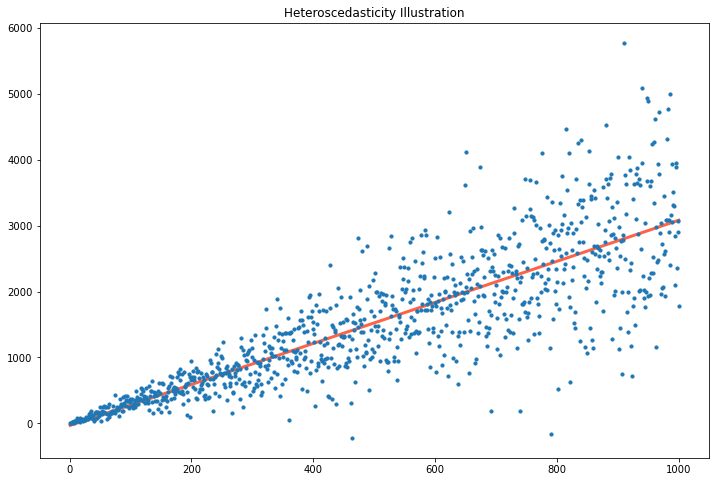

In [4]:
u = np.random.randn(1000)
X = np.arange(1, 1001)
Y = 4+3*X + X*u
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(X, Y, s=10)
reg_results = sp.stats.linregress(X,Y)
Y_fitted = reg_results[1]+X*reg_results[0]
ax.plot(X, Y_fitted, color = 'tomato', lw = 3, zorder = 0)
ax.set_title('Heteroscedasticity Illustration')
plt.show()

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<b>The Fact of Heteroscedasticity Without Proof:</b><br>
Heteroscedasticity doesn't cause <i>unbiased</i> and <i>inconsistency</i>, but it renders OLS estimator <i>inefficient</i>, which means given the same amount of data, there will be other estimation methods other than OLS possessing smaller variances of estimated coefficients. In other words, the OLS will not be a <i>Best Linear Unbiased Estimator</i> (BLUE) when data is plagued with heteroscedasticity. 
</div>





## <font face="gotham" color="purple"> How To Detect Heteroscedasticity </font>

You might think it's blatantly obvious to detect heteroscedasticity just like the graph above. Social science data or economic data are much sparse than data from other sciences, it wouldn't be so easy to determine whether a dataset is heteroscedastic by eyeballing. In economic studies, we usually have only one observation of $Y$ corresponding to a particular value of $X$, therefore detecting heteroscedasticity also requires guesswork and prior empirical experiences.

Also similar to multicollinearity, heteroscedasticity is more a matter of degree rather than presence or not.

Because most of time we are unable to access the information of population disturbance term, so the methods of detection are based on the residuals $e$ since they are the ones we observe.

### <font face="gotham" color="purple"> Graphical Method </font>

Most straightforward method is to plot $e$ against one of $X$. For instance, we can use the same simulated data and plot residual $e$ against independent variable $X$. Though residuals are not the same as disturbance term, they can be used as proxies given the sample size is large enough.

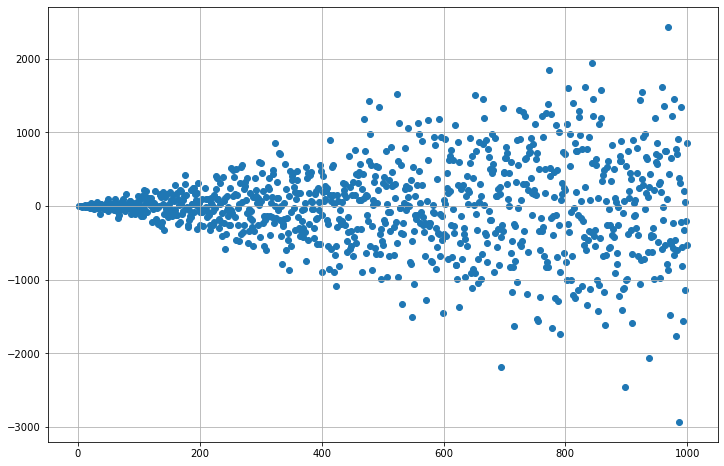

In [145]:
resid = Y - Y_fitted
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
ax.scatter(X, resid)
plt.show()

## <font face="gotham" color="purple"> Statistical Methods </font>

Some statistical tests will help determine if the data has heteroscedastic issue.

### <font face="gotham" color="purple">Goldfeld–Quandt Test </font>

Goldfeld-Quandt test is the most popular test for heteroscedasticity, the test assumes the $\sigma_{u_i}$ is proportional (or inversely) to $X$. The test sorts the sample by the magnitude of $X$, then run two separate regressions with first $n'$ and last $n'$ observations, and denote the residual sums of squares $RSS_1$ and $RSS_2$ respectively, the rest of $n-2n'$ observations are dropped. The rule of thumb is 
$$
n' = \frac{3n}{8}
$$
Hypotheses are
$$
H_0: \text{$RSS_2$ is not significantly larger (smaller) than $RSS_1$}\\
H_1: \text{$RSS_2$ is significantly larger (smaller) than $RSS_1$}
$$
The test statistic $\frac{RSS_2}{RSS_1}$ has $F$-distribution with $(n'-k)$ and $(n'-k)$ degree of freedom. Here's a demonstration of G-Q test, dots with different colors are different groups, two subregressions are done with its regression line accordingly. Though it might not be obvious to notice, two regression lines have different slopes, that means heteroskedascity might lead on unreliable estimations. 

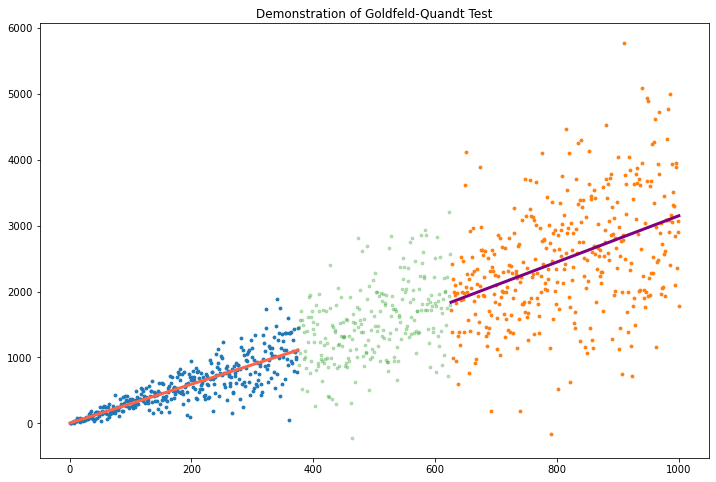

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))

n_apos = round(3/8*len(Y))

ax.scatter(X[0:n_apos], Y[0:n_apos], s = 8)
reg_result_1 = sp.stats.linregress(X[0:n_apos],Y[0:n_apos])
Y_fitted = reg_result_1[1]+X[0:n_apos]*reg_result_1[0]
ax.plot(X[0:n_apos], Y_fitted, color = 'tomato', lw = 3, zorder = 4)

ax.scatter(X[-n_apos:], Y[-n_apos:], s =8)
reg_result_2 = sp.stats.linregress(X[-n_apos:],Y[-n_apos:])
Y_fitted = reg_result_2[1]+X[-n_apos:]*reg_result_2[0]
ax.plot(X[-n_apos:], Y_fitted, color = 'purple', lw = 3, zorder = 4)

ax.set_title('Demonstration of Goldfeld-Quandt Test')
ax.scatter(X[round(3/8*len(Y)):-round(3/8*len(Y))], Y[round(3/8*len(Y)):-round(3/8*len(Y)):], alpha = .3, s = 8)
plt.show()

### <font face="gotham" color="purple">Breusch–Pagan–Godfrey Test</font>

The problem of G-Q test is that depends on correctly identification of $X$, i.e. you need to know which know which $X$ disturbance term is proportional to. It's straightforward in simple linear regression, but you will have to try with every independent variable in multiple regression. But Breusch-Pagan-Godfrey test is more general, here is how we perform B-P-G test, consider the $k$-variable model 
$$
Y_{i}=\beta_{1}+\beta_{2} X_{2 i}+\cdots+\beta_{k} X_{k i}+u_{i}
$$
1. Estimate the model with OLS
2. Obtain estimated variance of disturbance term with $\hat{\sigma}^2=\frac{1}{n}\sum_{i=1}^ne_i^2$, where $e_i$'s are residuals.
3. Construct an auxiliary regression, where $m\leq k$
$$
\frac{e_i^2}{\hat{\sigma}^2}=\alpha_{1}+\alpha_{2} Z_{2 i}+\cdots+\alpha_{m} Z_{m i}+v_{i}
$$
4. Obtain $ESS$, define a statistic
$$
\frac{ESS}{2}\sim \chi_{m-1}^2
$$

We reject the null hypothesis of homoskedasticity if computed $\frac{ESS}{2}$ is larger than critical $\chi^2$ value at the chosen level of significance. B-P-G test replies on normality assumption of disturbance term, so you can test if residuals has approximately normal distribution or not. 

### <font face="gotham" color="purple">White’s General Heteroscedasticity Test</font>

The most general test is White's Test, consider a two independent variables regression
$$
Y_{i}=\beta_{1}+\beta_{2} X_{2 i}+\beta_{3} X_{3 i}+u_{i}
$$
1. Estimate the model above with OLS, obtain the residuals.
2. Run auxiliary regression
$$
e_{i}^{2}=\alpha_{1}+\alpha_{2} X_{2 i}+\alpha_{3} X_{3 i}+\alpha_{4} X_{2 i}^{2}+\alpha_{5} X_{3 i}^{2}+\alpha_{6} X_{2 i} X_{3 i}+v_{i}
$$
3. Obtain $R^2$, construct test statistic, $k$ is the number of independent variables
$$
nR^2\sim \chi_k^2
$$
4. Hypotheses are
$$
H_0:  \alpha_2 = \alpha_3 =\alpha_4=\alpha_5=\alpha_6=0\\
H_1:  \text{any of $\alpha_i$'s isn't $0$}
$$

## <font face="gotham" color="purple"> Remedies to Heteroscedasticity </font>

If $\sigma_i^2$ is known, **weighted least square** (WLS) is the best choice, i.e. divide $\sigma_i$ on both sides of the model, which can correct the heteroscedasticity and estimator will be BLUE. However $\sigma_i^2$ is rarely known, we won't even bother to discuss this situation. 

If we don't know the $\sigma_i^2$ and suspect heteroscedasticity, you can invoke a **White Robust Standard Errors**. If the difference is large comparing with OLS standard errors, we should routinely prefer to results with robust standard errors. If you estimate with statsmodel library, the OLS object has a property for robust standard error ```model.HC0_se```

However, there are also possibilities of mending heteroscedasticity with model specification, which is based on your assumption of variable relations. 

### <font face="gotham" color="purple"> Weighted Least Squares </font>

To be added....

### <font face="gotham" color="purple"> Function Relationship </font>

If we assume the disturbance term has a function relationship with variables, i.e.
$$
E(u_i^2) = \sigma^2 f(X_i) \qquad\text{ or } \qquad  E(u_i^2) = \sigma^2 f(Y_i)
$$
Suppose we are dealing with simple linear regression model
$$
Y_i = \beta_1 +\beta_2 X_i + u_i
$$
To eliminate the heteroscedasiticity given the known function form, we divide both sides by $g(f(x))$
$$
\frac{Y_i}{g(f(X_i))}=\frac{\beta_1}{g(f(X_i))}+\frac{\beta_2 X_i}{g(f(X_i))}+\frac{u_i}{g(f(X_i))}
$$

What we want is to achieve
$$
E\bigg(\frac{u_i}{g(f(X_i))}\bigg)^2=\sigma^2
$$

Thus if $f(X_i)=X_i^2$, then $g(\cdot)$ is the inverse of $f(\cdot)$

### <font face="gotham" color="purple"> Log Transformation </font>

Log transformation can largely contain the heteroscedasticity, because it compresses the scales. In the chart below we have plotted both $Y_i= \beta_1+\beta_2X_i+u_i$ and $ln{Y_i}= \beta_1+\beta_2\ln{X_i}+u_i$, the scales of latter are heavily compressed, for instance, $6000$ is $6$ times of $1000$, but $\ln{6000}\approx 8.7$ is only $.26$ times higher than $\ln{1000}\approx 6.9$. This is the exact mathematical reason why log transformation can treat heteroscedasticity. 

However, the log operation will be invalid with negative numbers, that's why the chart below might have error messages _'invalid value encountered in log'_.

<ipython-input-62-a14a11757e74>:8: RuntimeWarning: invalid value encountered in log
  ax[1].scatter(np.log(X), np.log(Y), color = 'tomato')


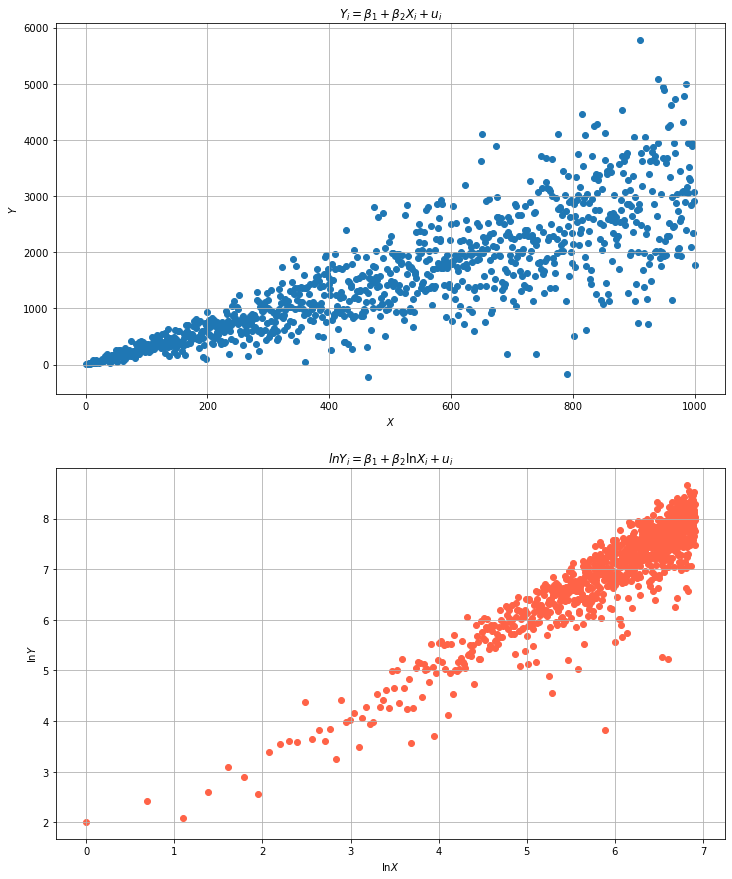

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))
ax[0].scatter(X, Y)
ax[0].grid()
ax[0].set_title(r'$Y_i= \beta_1+\beta_2X_i+u_i$')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')

ax[1].scatter(np.log(X), np.log(Y), color = 'tomato')
ax[1].grid()
ax[1].set_title(r'$ln{Y_i}= \beta_1+\beta_2\ln{X_i}+u_i$')
ax[1].set_xlabel('$\ln{X}$')
ax[1].set_ylabel('$\ln{Y}$')

plt.show()

In [113]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'Mortality_NI_WB_2019')
df.head()

,Country_Name,Series_Name,2019
0,Algeria,mortality_rate_per_1000,20.000000
1,Algeria,NI_perCap_2010constUSD,3593.098781
2,Angola,mortality_rate_per_1000,50.200000
3,Angola,NI_perCap_2010constUSD,1863.318585
4,Argentina,mortality_rate_per_1000,8.200000


In [114]:
df_mort = df[df['Series_Name']=='mortality_rate_per_1000']
df_NI = df[df['Series_Name']=='NI_perCap_2010constUSD']

In [128]:
reg_results = sp.stats.linregress(df_NI[2019], df_mort[2019])
X = np.arange(np.max(df_NI[2019]))
Y_fit =  reg_results[1]+reg_results[0]*X

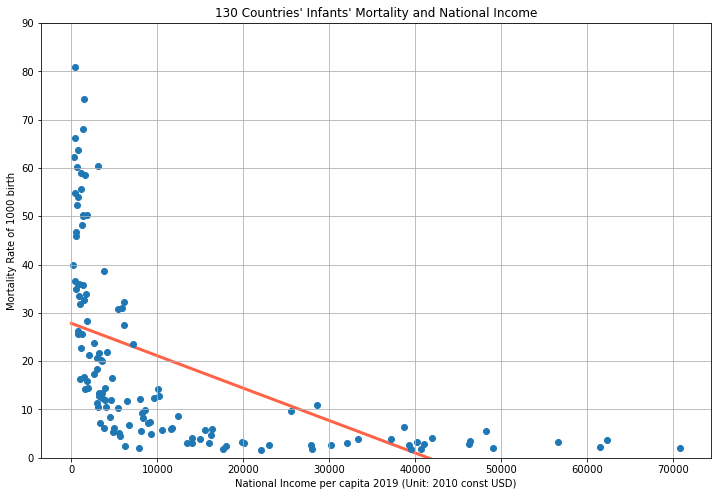

In [135]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(df_NI[2019], df_mort[2019])
ax.plot(X, Y_fit, color = 'tomato', lw = 3, zorder =0)
ax.set_xlabel('National Income per capita 2019 (Unit: 2010 const USD)')
ax.set_title("130 Countries' Infants' Mortality and National Income")
ax.set_ylabel('Mortality Rate of 1000 birth')
ax.set_ylim([0, 90])
ax.grid()